In [1]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
img = np.load(
    "../../100_data/test_spec.npz",
    allow_pickle=True,
)
aug = np.load(
    "../201_processing/augmented_spec.npz",
    allow_pickle=True,
)
X_tr = aug["X_train"]
y_tr = aug["y_train"]

img_X = img["X"]
img_y = img["y"]
X_tr.shape, y_tr.shape

((4794, 128, 128, 3), (4794,))

In [11]:
from sklearn.model_selection import train_test_split

_, X_te, _, y_te = train_test_split(img_X, img_y, test_size=0.2, random_state=42)

In [12]:
y_tr

array(['pop', 'pop', 'pop', ..., 'classical', 'classical', 'classical'],
      dtype='<U9')

In [13]:
genre_names = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

# Get y train values from strings to ints
genre_to_index = {genre: idx for idx, genre in enumerate(genre_names)}

# Convert genre names to their numeric index
y_tr = np.array([genre_to_index[genre] for genre in y_tr])
y_tr.shape

(4794,)

In [15]:
X_train = torch.from_numpy(X_tr)
# y_ohe_tr = torch.from_numpy(y_tr)
y_train = torch.from_numpy(y_tr)

X_test = torch.from_numpy(X_te)
y_ohe_te = torch.from_numpy(y_te)
y_test = torch.argmax(y_ohe_te, dim=1)

In [16]:
X_train_perm = X_train.permute(
    0, 3, 1, 2
)  # This changes the shape to [799, 3, 128, 128]

X_train_perm.shape

torch.Size([4794, 3, 128, 128])

In [17]:
y_train.shape

torch.Size([4794])

In [18]:
from torch.utils.data import TensorDataset


# Compute the mean and std for each channel (across the training data)
# mean = X_train_perm.mean(dim=[0, 2, 3])  # Mean per channel (R, G, B)
# std = X_train_perm.std(dim=[0, 2, 3])    # Std per channel (R, G, B)

# Step 3: Normalize the images
# X_train_normalized = (X_train_perm - mean[:, None, None]) / std[:, None, None]

# Now X_train_normalized contains the normalized images, and you can create the TensorDataset
train_dataset_n = TensorDataset(X_train_perm, y_train)

X_test_perm = X_test.permute(0, 3, 1, 2)  # Reorder test data dimensions
# X_test_normalized = (X_test_perm - mean[:, None, None]) / std[:, None, None]
test_dataset = TensorDataset(X_test_perm, y_test)

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_n, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train FC6

In [20]:
vgg16_6 = models.vgg16(pretrained=True)

/Users/rishikarandev/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rishikarandev/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/rishikarandev/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 57.8MB/s] 


In [21]:
vgg16_6.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
list(vgg16_6.classifier.children())[:-6]

[Linear(in_features=25088, out_features=4096, bias=True)]

In [23]:
vgg16_6.classifier = torch.nn.Sequential(*list(vgg16_6.classifier.children())[:-6])

In [24]:
vgg16_6.classifier[0]

Linear(in_features=25088, out_features=4096, bias=True)

In [25]:
num_ftrs = vgg16_6.classifier[0].in_features
vgg16_6.classifier[0] = torch.nn.Linear(num_ftrs, 10)  # 10 music genres

# Freeze convolutional layers (optional)
for param in vgg16_6.features.parameters():
    param.requires_grad = False

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_6 = vgg16_6.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    vgg16_6.classifier.parameters(), lr=0.001
)  # only fine-tuning classifier

# Train
num_epochs = 50

for epoch in range(num_epochs):
    vgg16_6.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16_6(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%"
    )

print("Fine-tuning complete.")

Epoch [1/50], Loss: 0.9477, Accuracy: 68.52%


KeyboardInterrupt: 

In [ ]:
# Testing
vgg16_6.eval()

with torch.no_grad():
    outputs = vgg16_6(X_test_perm.to(device).type(torch.float32))
    _, predicted6 = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted6 == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 62.00%


              precision    recall  f1-score   support

       blues       0.64      0.67      0.65        21
   classical       0.92      0.92      0.92        12
     country       0.50      0.62      0.56        24
       disco       0.58      0.32      0.41        22
      hiphop       0.55      0.80      0.65        15
        jazz       0.92      0.89      0.91        27
       metal       0.79      0.83      0.81        18
         pop       0.50      0.47      0.49        19
      reggae       0.65      0.50      0.56        22
        rock       0.27      0.30      0.29        20

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.63      0.62      0.62       200



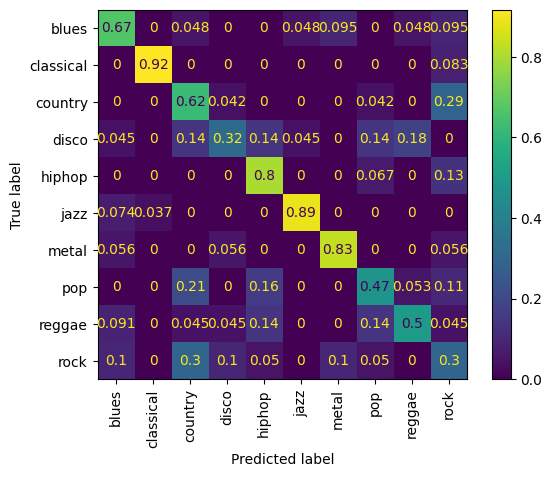

In [ ]:
# CM and CM display
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

actual = y_test.cpu().numpy()
preds6 = predicted6.cpu().numpy()

print(classification_report(actual, preds6, target_names=genre_labels))
cm  = confusion_matrix(actual, preds6, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot()
plt.xticks(rotation=90)
plt.show()

Training FC7

In [ ]:
vgg16_7 = models.vgg16(pretrained=True)
#vgg16_7.classifier = torch.nn.Sequential(*list(vgg16_7.classifier.children())[:-2])
vgg16_7.classifier

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
vgg16_7.classifier = torch.nn.Sequential(*list(vgg16_7.classifier.children())[:-3])
vgg16_7.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

In [ ]:
num_ftrs = vgg16_7.classifier[3].in_features
vgg16_7.classifier[3] = torch.nn.Linear(num_ftrs, 10) # 10 music genres

# Freeze convolutional layers (optional)
for param in vgg16_7.features.parameters():
    param.requires_grad = False

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_7 = vgg16_7.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_7.classifier.parameters(), lr=0.001)  # only fine-tuning classifier

# Training
num_epochs = 50

for epoch in range(num_epochs):
    vgg16_7.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16_7(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")

Epoch [1/50], Loss: 3.9597, Accuracy: 32.17%
Epoch [2/50], Loss: 1.1938, Accuracy: 59.20%
Epoch [3/50], Loss: 0.9546, Accuracy: 67.21%
Epoch [4/50], Loss: 0.6991, Accuracy: 75.59%
Epoch [5/50], Loss: 0.5810, Accuracy: 80.73%
Epoch [6/50], Loss: 0.5075, Accuracy: 81.73%
Epoch [7/50], Loss: 0.4081, Accuracy: 85.11%
Epoch [8/50], Loss: 0.3839, Accuracy: 85.48%
Epoch [9/50], Loss: 0.3346, Accuracy: 88.11%
Epoch [10/50], Loss: 0.2633, Accuracy: 89.86%
Epoch [11/50], Loss: 0.2014, Accuracy: 93.87%
Epoch [12/50], Loss: 0.1881, Accuracy: 93.49%
Epoch [13/50], Loss: 0.2228, Accuracy: 91.61%
Epoch [14/50], Loss: 0.2050, Accuracy: 92.62%
Epoch [15/50], Loss: 0.2391, Accuracy: 91.49%
Epoch [16/50], Loss: 0.1452, Accuracy: 94.87%
Epoch [17/50], Loss: 0.1624, Accuracy: 94.12%
Epoch [18/50], Loss: 0.0737, Accuracy: 97.87%
Epoch [19/50], Loss: 0.0919, Accuracy: 97.50%
Epoch [20/50], Loss: 0.0793, Accuracy: 98.25%
Epoch [21/50], Loss: 0.1199, Accuracy: 95.99%
Epoch [22/50], Loss: 0.1246, Accuracy: 96.2

In [ ]:
# Testing
vgg16_7.eval()

with torch.no_grad():
    outputs = vgg16_7(X_test_perm.to(device).type(torch.float32))
    _, predicted7 = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted7 == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 62.00%


              precision    recall  f1-score   support

       blues       0.74      0.67      0.70        21
   classical       0.85      0.92      0.88        12
     country       0.49      0.75      0.59        24
       disco       0.56      0.45      0.50        22
      hiphop       0.52      0.80      0.63        15
        jazz       1.00      0.89      0.94        27
       metal       0.79      0.83      0.81        18
         pop       0.43      0.47      0.45        19
      reggae       0.70      0.32      0.44        22
        rock       0.25      0.20      0.22        20

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.64      0.62      0.61       200



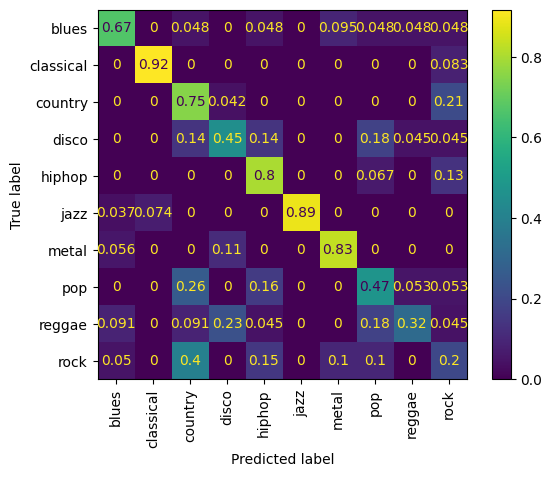

In [ ]:
preds7 = predicted7.cpu().numpy()

print(classification_report(actual, preds7, target_names=genre_labels))
cm  = confusion_matrix(actual, preds7, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot()
plt.xticks(rotation=90)
plt.show()

Training FC8

In [ ]:
# 1. Load pre-trained VGG16
vgg16_8 = models.vgg16(pretrained=True)
vgg16_8.classifier

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# Replace the last fully connected layer
num_ftrs = vgg16_8.classifier[6].in_features
vgg16_8.classifier[6] = torch.nn.Linear(num_ftrs, 10) # 10 music genres

# Freeze convolutional layers (optional)
for param in vgg16_8.features.parameters():
    param.requires_grad = False


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_8 = vgg16_8.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_8.classifier.parameters(), lr=0.001)  # only fine-tuning classifier

# Training
num_epochs = 50

for epoch in range(num_epochs):
    vgg16_8.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16_8(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")


Epoch [1/50], Loss: 2.3822, Accuracy: 20.15%
Epoch [2/50], Loss: 1.8188, Accuracy: 36.42%
Epoch [3/50], Loss: 1.5072, Accuracy: 45.43%
Epoch [4/50], Loss: 1.3129, Accuracy: 55.07%
Epoch [5/50], Loss: 1.1685, Accuracy: 59.70%
Epoch [6/50], Loss: 1.1047, Accuracy: 61.95%
Epoch [7/50], Loss: 0.9892, Accuracy: 65.83%
Epoch [8/50], Loss: 0.9471, Accuracy: 68.96%
Epoch [9/50], Loss: 0.9358, Accuracy: 70.09%
Epoch [10/50], Loss: 0.7987, Accuracy: 73.84%
Epoch [11/50], Loss: 0.6905, Accuracy: 77.35%
Epoch [12/50], Loss: 0.7095, Accuracy: 78.22%
Epoch [13/50], Loss: 0.7580, Accuracy: 76.35%
Epoch [14/50], Loss: 0.7296, Accuracy: 77.97%
Epoch [15/50], Loss: 0.8104, Accuracy: 77.85%
Epoch [16/50], Loss: 0.7397, Accuracy: 78.85%
Epoch [17/50], Loss: 0.8268, Accuracy: 77.10%
Epoch [18/50], Loss: 0.7681, Accuracy: 77.35%
Epoch [19/50], Loss: 0.6215, Accuracy: 82.98%
Epoch [20/50], Loss: 0.6057, Accuracy: 81.85%
Epoch [21/50], Loss: 0.5427, Accuracy: 82.23%
Epoch [22/50], Loss: 0.6111, Accuracy: 81.7

In [ ]:
# Testing
vgg16_8.eval()

with torch.no_grad():
    outputs = vgg16_8(X_test_perm.to(device).type(torch.float32))
    _, predicted8 = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted8 == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 63.50%


              precision    recall  f1-score   support

       blues       0.59      0.48      0.53        21
   classical       1.00      0.83      0.91        12
     country       0.53      0.79      0.63        24
       disco       0.55      0.55      0.55        22
      hiphop       0.61      0.73      0.67        15
        jazz       0.96      0.93      0.94        27
       metal       0.84      0.89      0.86        18
         pop       0.83      0.26      0.40        19
      reggae       0.57      0.55      0.56        22
        rock       0.28      0.35      0.31        20

    accuracy                           0.64       200
   macro avg       0.68      0.64      0.64       200
weighted avg       0.67      0.64      0.63       200



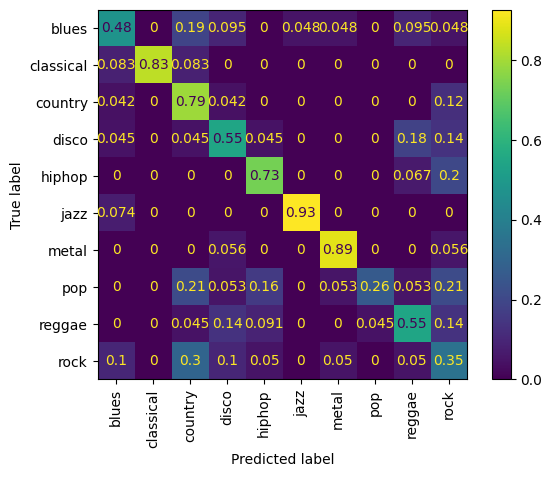

In [ ]:
preds8 = predicted8.cpu().numpy()

print(classification_report(actual, preds8, target_names=genre_labels))
cm  = confusion_matrix(actual, preds8, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
disp.plot()
plt.xticks(rotation=90)
plt.show()

Nothing Frozen - FC8 (I adjusted lr to 1e-5!)

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# Replace the last fully connected layer
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_ftrs, 10) # 10 music genres

for param in vgg16.parameters():
    param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)  # fine-tune all

# Training
num_epochs = 50

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vgg16(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 2.2371, Accuracy: 17.52%
Epoch [2/50], Loss: 1.9769, Accuracy: 31.29%
Epoch [3/50], Loss: 1.6540, Accuracy: 45.68%
Epoch [4/50], Loss: 1.3473, Accuracy: 52.19%
Epoch [5/50], Loss: 1.1304, Accuracy: 60.20%
Epoch [6/50], Loss: 0.9745, Accuracy: 65.33%
Epoch [7/50], Loss: 0.8564, Accuracy: 72.09%
Epoch [8/50], Loss: 0.7161, Accuracy: 75.34%
Epoch [9/50], Loss: 0.6282, Accuracy: 78.10%
Epoch [10/50], Loss: 0.5563, Accuracy: 81.10%
Epoch [11/50], Loss: 0.4551, Accuracy: 84.11%
Epoch [12/50], Loss: 0.3691, Accuracy: 87.48%
Epoch [13/50], Loss: 0.3164, Accuracy: 89.24%
Epoch [14/50], Loss: 0.2765, Accuracy: 90.61%
Epoch [15/50], Loss: 0.2117, Accuracy: 93.12%
Epoch [16/50], Loss: 0.1598, Accuracy: 94.87%
Epoch [17/50], Loss: 0.1230, Accuracy: 97.25%
Epoch [18/50], Loss: 0.1203, Accuracy: 96.25%
Epoch [19/50], Loss: 0.0778, Accuracy: 98.37%
Epoch [20/50], Loss: 0.0632, Accuracy: 98.62%
Epoch [21/50], Loss: 0.0635, Accuracy: 98.50%
Epoch [22/50], Loss: 0.0389, Accuracy: 99.0

In [ ]:
# Testing
vgg16.eval()

with torch.no_grad():
    outputs = vgg16(X_test_perm.to(device).type(torch.float32))
    _, predicted = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 76.00%


              precision    recall  f1-score   support

       blues       0.88      0.71      0.79        21
   classical       0.92      1.00      0.96        12
     country       0.69      0.75      0.72        24
       disco       0.70      0.64      0.67        22
      hiphop       0.74      0.93      0.82        15
        jazz       0.93      0.93      0.93        27
       metal       0.94      0.94      0.94        18
         pop       0.58      0.58      0.58        19
      reggae       0.80      0.73      0.76        22
        rock       0.48      0.50      0.49        20

    accuracy                           0.76       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.76      0.76      0.76       200



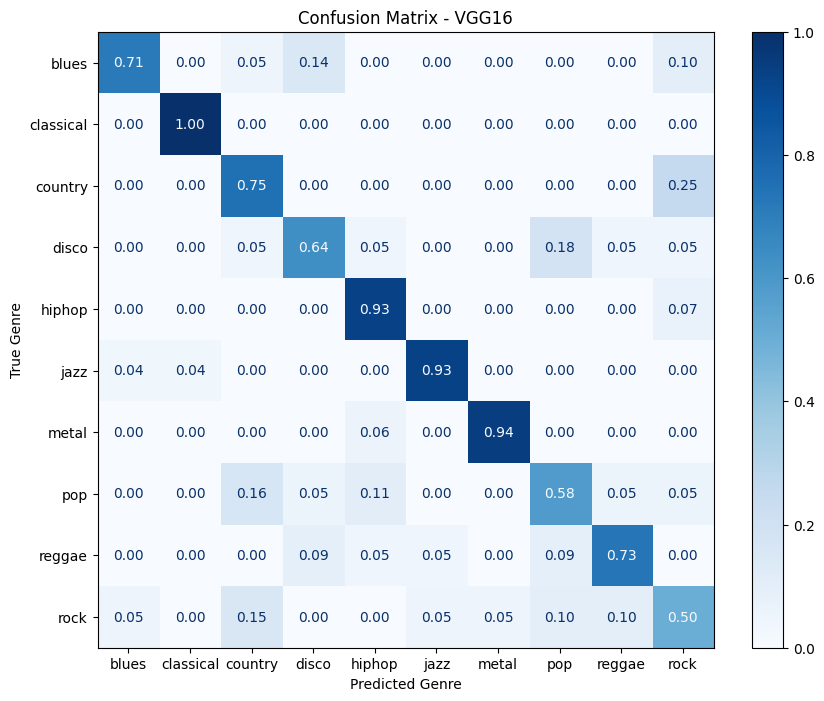

<Figure size 1000x800 with 0 Axes>

In [ ]:
preds = predicted.cpu().numpy()

print(classification_report(actual, preds, target_names=genre_labels))
cm  = confusion_matrix(actual, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)

plt.figure(figsize=(10, 8))
ax.set_xlabel("Predicted Genre")
ax.set_ylabel("True Genre")
ax.set_title("Confusion Matrix - VGG16")
plt.tight_layout()
plt.show()

Old Stuff

In [ ]:
from torch.utils.data import TensorDataset, Subset, random_split

dataset = TensorDataset(X_tensor, y_tensor)

# Step 2: Shuffle the dataset indices
num_samples = len(dataset)
shuffled_indices = torch.randperm(num_samples)

# Step 3: Split the shuffled indices
train_size = int(0.8 * num_samples)
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

# Step 4: Create training and testing datasets directly
X_train = X_tensor[train_indices]
y_train = y_tensor[train_indices]
X_test = X_tensor[test_indices]
y_test = y_tensor[test_indices]

#train_dataset = TensorDataset(X_train, y_train)
#test_dataset = TensorDataset(X_test, y_test)

NameError: name 'X_tensor' is not defined